# Мобильное приложение "Ненужные вещи"

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет mobile_dataset.csv содержит колонки:
- event.time — время совершения
- event.name — название события
- user.id — идентификатор пользователя

Датасет mobile_sources.csv содержит колонки:
- userId — идентификатор пользователя
- source — источник, с которого пользователь установил приложение

Расшифровки событий:
- advert_open — открытие карточки объявления
- photos_show — просмотр фотографий в объявлении
- tips_show — пользователь увидел рекомендованные объявления
- tips_click — пользователь кликнул по рекомендованному объявлению
- contacts_show и show_contacts — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- contacts_call — пользователь позвонил по номеру телефона на карточке объявления
- map — пользователь открыл карту размещенных объявлений
- search_1 — search_7 — разные события, связанные с поиском по сайту
- favorites_add — добавление объявления в избранное

## Просмотр начальных данных

In [1]:
import pandas as pd
import math
import cmath
import numpy as np
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from warnings import simplefilter
import math as mth
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
dataset = pd.read_csv('/datasets/mobile_dataset.csv')

In [3]:
sources=pd.read_csv('/datasets/mobile_soures.csv')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
event.time    74197 non-null object
event.name    74197 non-null object
user.id       74197 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


In [5]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
userId    4293 non-null object
source    4293 non-null object
dtypes: object(2)
memory usage: 67.2+ KB


In [6]:
dataset['event.name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

**Из предварительного просмотра нужно поменять названия столбцов, изменить тип данных для столбца event.time, так же есть события с одинаковым смыслом, которые надо объединить**

## Предобработка данных

### Переименование колонок

In [7]:
dataset.columns=['event_time','event_name','user_id']

In [8]:
sources.columns=['user_id','source']

### Изменение типов данных

In [9]:
dataset['event_time'] = pd.to_datetime(dataset['event_time'])
dataset['dt'] = dataset['event_time'].dt.strftime('%Y-%m-%d')
dataset['dt'] = pd.to_datetime(dataset['dt'])
dataset['weekday']=dataset['event_time'].dt.weekday
dataset['event_hour'] = dataset['event_time'].dt.hour

In [10]:
dataset

,event_time,event_name,user_id,dt,weekday,event_hour
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0,0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0,0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0,0
...,...,...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,6,23
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,6,23
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,2019-11-03,6,23
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,6,23


### Объединение событий show_contacts и contacts_show

In [11]:
dataset.loc[dataset["event_name"]=="show_contacts", "event_name"] = "contacts_show"

In [12]:
dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

### Объедение search_1..7 в одно событие search

Функция изменяет название события на search, если в нем есть search

In [13]:
def search_type(i):
    if 'search'in i:
        new_name='search'
        return new_name
    return i

In [14]:
dataset['event_name']=dataset['event_name'].apply(search_type)
dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

### Поиск дубликатов и пропусков

In [15]:
dataset.duplicated().sum()

0

In [16]:
sources.duplicated().sum()

0

In [17]:
dataset.isnull().sum()

event_time    0
event_name    0
user_id       0
dt            0
weekday       0
event_hour    0
dtype: int64

In [18]:
sources.isnull().sum()

user_id    0
source     0
dtype: int64

Дубликатов и пропусков нет в таблицах.

## Исследовательский анализ 

### Объединение таблиц в одну

In [19]:
new_dataset=dataset[['event_name', 'user_id','event_time','dt','event_hour',]]

In [20]:
df=new_dataset.merge(sources,on='user_id')
df

,event_name,user_id,event_time,dt,event_hour,source
0,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00.431357,2019-10-07,0,other
1,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:01.236320,2019-10-07,0,other
2,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:07.039334,2019-10-07,0,other
3,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:01:27.770232,2019-10-07,0,other
4,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:01:34.804591,2019-10-07,0,other
...,...,...,...,...,...,...
74192,map,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03 23:46:47.068179,2019-11-03,23,google
74193,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03 23:46:58.914787,2019-11-03,23,google
74194,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03 23:47:01.232230,2019-11-03,23,google
74195,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,2019-11-03 23:47:47.475102,2019-11-03,23,google


### Количество уникальных пользователей

In [21]:
df['user_id'].nunique()

4293

### Среднее уникальное количество пользователей в день

In [22]:
dau_total = df.groupby('dt').agg({'user_id': 'nunique'}).mean()
dau_total[0]

279.17857142857144

### Среднее количество событий на пользователя

In [23]:
df.shape[0]/df['user_id'].nunique()

17.283251805264385

### Количество уникальных пользователей по события. Доля пользователей, которые хоть раз совершали событие.

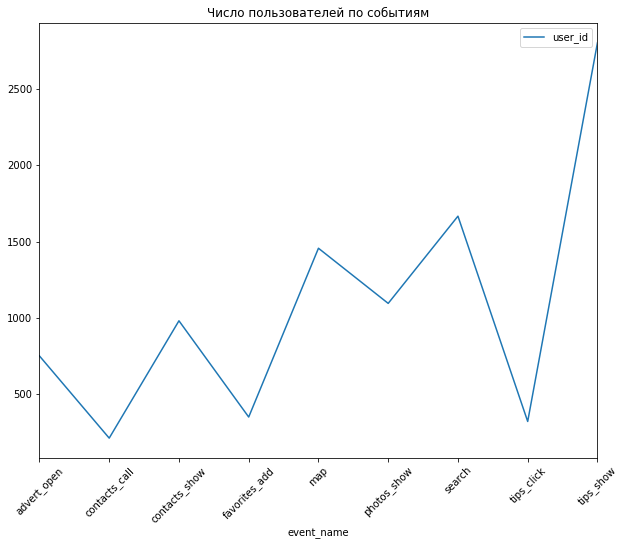

In [24]:
(df
.groupby(['event_name'])
.agg({'user_id': 'nunique'})
.reset_index()
.plot(x='event_name', y='user_id', rot=45, figsize = (10, 8), title = 'Число пользователей по событиям')
)

In [25]:
funnel = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})
funnel['percent'] = funnel['total_users']/df['user_id'].nunique()*100
funnel

,event_name,total_users,percent
0,tips_show,2801,65.245749
1,search,1666,38.807361
2,map,1456,33.915677
3,photos_show,1095,25.506639
4,contacts_show,981,22.851153
5,advert_open,751,17.493594
6,favorites_add,351,8.176101
7,tips_click,322,7.500582
8,contacts_call,213,4.961565


### Какие события есть, как часто они встречаются, сортировка событий по частоте

In [26]:
events_count =df.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id',ascending=False)\
    .rename(columns={'user_id':'total_events'})
events_count

,event_name,total_events
8,tips_show,40055
5,photos_show,10012
6,search,6784
0,advert_open,6164
2,contacts_show,4529
4,map,3881
3,favorites_add,1417
7,tips_click,814
1,contacts_call,541


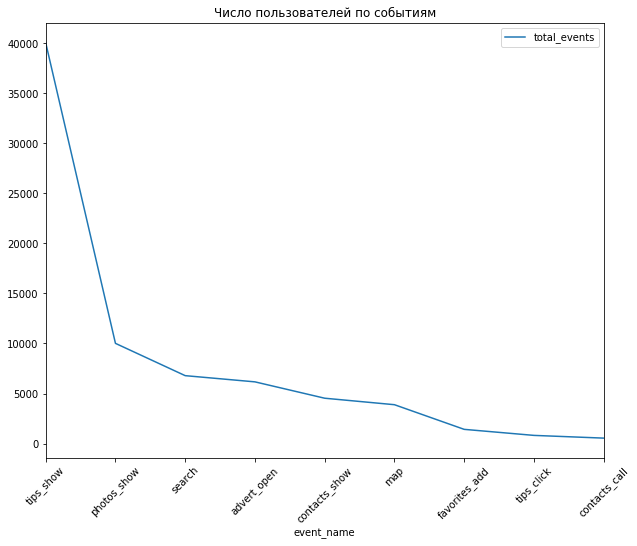

In [27]:
events_count.plot(x='event_name', y='total_events', rot=45, figsize = (10, 8), title = 'Число пользователей по событиям')
plt.show()

Самое популярное действие tips_show (пользователь увидел рекомендованные объявления) - 40055.
Затем photos_show (просмотр фотографий в объявлении) - больше 10000.
Действие search (события, связанные с поиском по сайту) - около 6700.
Самые редкие действия - tips_click(пользователь кликнул по рекомендованному объявлению), contacts_call(пользователь позвонил по номеру телефона на карточке объявления).

## Сегментация пользователей на основе действий

In [28]:
users = df.groupby('user_id').agg({'user_id':'nunique'})
users = users.rename(columns={'user_id':'users'})

tips_show = df.query('event_name=="tips_show"').groupby('user_id', as_index=False).agg({'event_name':'count'})
tips_show = tips_show.rename(columns={'event_name':'tips_show'})

maps = df.query('event_name=="map"').groupby('user_id', as_index=False).agg({'event_name':'count'})
maps = maps.rename(columns={'event_name':'maps'})

favorites_add = df.query('event_name=="favorites_add"').groupby('user_id', as_index=False).agg({'event_name':'count'})
favorites_add = favorites_add.rename(columns={'event_name':'favorites_add'})

tips_click = df.query('event_name=="tips_click"').groupby('user_id', as_index=False).agg({'event_name':'count'})
tips_click = tips_click.rename(columns={'event_name':'tips_click'})

photos_show = df.query('event_name=="photos_show"').groupby('user_id', as_index=False).agg({'event_name':'count'})
photos_show = photos_show.rename(columns={'event_name':'photos_show'})

In [29]:
marks=pd.merge(users,maps,on='user_id',how='left')
marks=pd.merge(marks,photos_show,on='user_id',how='left')
marks['maps']=marks['maps'].fillna(0)
marks['photos_show']=marks['photos_show'].fillna(0)
marks=pd.merge(marks,favorites_add,on='user_id',how='left')
marks['favorites_add']=marks['favorites_add'].fillna(0)
marks=pd.merge(marks,tips_click,on='user_id',how='left')
marks['tips_click']=marks['tips_click'].fillna(0)
marks=pd.merge(marks,tips_show,on='user_id',how='left')
marks['tips_show']=marks['tips_show'].fillna(0)
marks

,user_id,users,maps,photos_show,favorites_add,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,6.0,0.0,0.0,0.0,29.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,1,0.0,33.0,2.0,0.0,0.0
2,00463033-5717-4bf1-91b4-09183923b9df,1,0.0,10.0,0.0,0.0,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,6.0,0.0,0.0,0.0,4.0
4,00551e79-152e-4441-9cf7-565d7eb04090,1,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,1,2.0,0.0,0.0,0.0,15.0
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1,0.0,6.0,0.0,0.0,0.0
4290,ffcf50d9-293c-4254-8243-4890b030b238,1,1.0,0.0,0.0,0.0,1.0
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,1,0.0,7.0,0.0,0.0,0.0


In [30]:
X = marks.drop(['user_id','users'], axis=1)

sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.show();

In [31]:
km = KMeans(n_clusters=4, random_state = 0) 
labels = km.fit_predict(X_sc) 

marks['cluster_km'] = labels
marks.head()

,user_id,users,maps,photos_show,favorites_add,tips_click,tips_show,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,6.0,0.0,0.0,0.0,29.0,0
1,00157779-810c-4498-9e05-a1e9e3cedf93,1,0.0,33.0,2.0,0.0,0.0,2
2,00463033-5717-4bf1-91b4-09183923b9df,1,0.0,10.0,0.0,0.0,0.0,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,6.0,0.0,0.0,0.0,4.0,0
4,00551e79-152e-4441-9cf7-565d7eb04090,1,0.0,1.0,0.0,0.0,0.0,0


In [32]:
users_of_cl = marks.groupby('cluster_km', as_index=False).count()[['cluster_km', 'user_id']].\
    rename(columns={'user_id': 'clusters_value'})

In [33]:
users_of_cl['percent'] = (users_of_cl['clusters_value'] / 4293) * 100
users_of_cl

,cluster_km,clusters_value,percent
0,0,4109,95.713953
1,1,75,1.747030
2,2,69,1.607268
3,3,40,0.931749


In [34]:
marks.groupby(['cluster_km']).mean().T

cluster_km,0,1,2,3
users,1.000000,1.000000,1.000000,1.000
maps,0.727428,9.733333,0.492754,3.200
photos_show,1.498661,0.000000,53.202899,4.575
favorites_add,0.145291,0.586667,1.942029,16.050
tips_click,0.109759,4.693333,0.000000,0.275
tips_show,7.673400,95.533333,2.130435,30.325


In [35]:
cluster_0=marks[marks['cluster_km']==0]
cluster_1=marks[marks['cluster_km']==1]
cluster_2=marks[marks['cluster_km']==2]
cluster_3=marks[marks['cluster_km']==3]

In [36]:
cluster_0

,user_id,users,maps,photos_show,favorites_add,tips_click,tips_show,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,6.0,0.0,0.0,0.0,29.0,0
2,00463033-5717-4bf1-91b4-09183923b9df,1,0.0,10.0,0.0,0.0,0.0,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,6.0,0.0,0.0,0.0,4.0,0
4,00551e79-152e-4441-9cf7-565d7eb04090,1,0.0,1.0,0.0,0.0,0.0,0
5,00554293-7e00-4122-b898-4e892c4a7c53,1,0.0,0.0,0.0,0.0,9.0,0
...,...,...,...,...,...,...,...,...
4287,ff82c7c7-16d6-44b1-833b-a217747b0b02,1,3.0,0.0,0.0,1.0,37.0,0
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,1,2.0,0.0,0.0,0.0,15.0,0
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1,0.0,6.0,0.0,0.0,0.0,0
4290,ffcf50d9-293c-4254-8243-4890b030b238,1,1.0,0.0,0.0,0.0,1.0,0


In [37]:
cluster_0=pd.merge(df,cluster_0,on='user_id',how='left').dropna()
cluster_1=pd.merge(df,cluster_1,on='user_id',how='left').dropna()
cluster_2=pd.merge(df,cluster_2,on='user_id',how='left').dropna()
cluster_3=pd.merge(df,cluster_3,on='user_id',how='left').dropna()

### Retetion rate - когортный анализ по неделям

**Для кластера 0:**

In [38]:
first_activity_date = cluster_0.groupby(['user_id'])['dt'].min()
first_activity_date.name = 'first_activity_date'
cluster_0 = cluster_0.join(first_activity_date,on='user_id')

In [39]:
cluster_0['activity_week'] = pd.to_datetime(cluster_0['dt'], unit='d') - pd.to_timedelta(cluster_0['dt'].dt.dayofweek, unit='d')
cluster_0['first_activity_week'] = pd.to_datetime(cluster_0['first_activity_date'], unit='d') - pd.to_timedelta(cluster_0['first_activity_date'].dt.dayofweek, unit='d')

In [40]:
cluster_0['cohort_lifetime']=cluster_0['activity_week']-cluster_0['first_activity_week']
cluster_0['cohort_lifetime']=cluster_0['cohort_lifetime']/np.timedelta64(1,'W')
cluster_0['cohort_lifetime']=cluster_0['cohort_lifetime'].astype('int')

In [41]:
cohorts=cluster_0.groupby(['first_activity_week','cohort_lifetime']).\
    agg({'user_id':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
cohorts=cohorts.merge(initial_users_count,on='first_activity_week')
cohorts['retention']=cohorts['user_id']/cohorts['cohort_users']
retention_pivot=cohorts.pivot_table(index='first_activity_week',columns='cohort_lifetime',values='retention',aggfunc='sum') 

In [42]:
retention_pivot

cohort_lifetime,0,1,2,3
first_activity_week,,,,
2019-10-07,1.0,0.209830,0.127599,0.085066
2019-10-14,1.0,0.217313,0.115419,NaN
2019-10-21,1.0,0.202844,NaN,NaN
2019-10-28,1.0,NaN,NaN,NaN


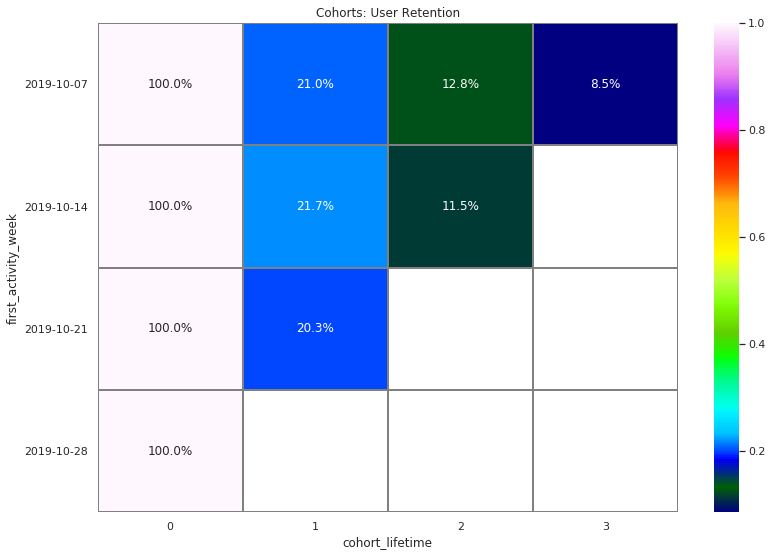

In [43]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',cmap='gist_ncar').set_yticklabels(retention_pivot.index.date)
plt.show()

В основном, 79-80%  не возвращается после первой недели.

**Для кластера 1:**

In [44]:
first_activity_date = cluster_1.groupby(['user_id'])['dt'].min()
first_activity_date.name = 'first_activity_date'
cluster_1 = cluster_1.join(first_activity_date,on='user_id')

In [45]:
cluster_1['activity_week'] = pd.to_datetime(cluster_1['dt'], unit='d') - pd.to_timedelta(cluster_1['dt'].dt.dayofweek, unit='d')
cluster_1['first_activity_week'] = pd.to_datetime(cluster_1['first_activity_date'], unit='d') - pd.to_timedelta(cluster_1['first_activity_date'].dt.dayofweek, unit='d')

In [46]:
cluster_1['cohort_lifetime']=cluster_1['activity_week']-cluster_1['first_activity_week']
cluster_1['cohort_lifetime']=cluster_1['cohort_lifetime']/np.timedelta64(1,'W')
cluster_1['cohort_lifetime']=cluster_1['cohort_lifetime'].astype('int')

In [47]:
cohorts=cluster_1.groupby(['first_activity_week','cohort_lifetime']).\
    agg({'user_id':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
cohorts=cohorts.merge(initial_users_count,on='first_activity_week')
cohorts['retention']=cohorts['user_id']/cohorts['cohort_users']
retention_pivot=cohorts.pivot_table(index='first_activity_week',columns='cohort_lifetime',values='retention',aggfunc='sum') 

In [48]:
retention_pivot

cohort_lifetime,0,1,2,3
first_activity_week,,,,
2019-10-07,1.0,0.781250,0.500000,0.40625
2019-10-14,1.0,0.727273,0.363636,NaN
2019-10-21,1.0,0.615385,NaN,NaN
2019-10-28,1.0,NaN,NaN,NaN


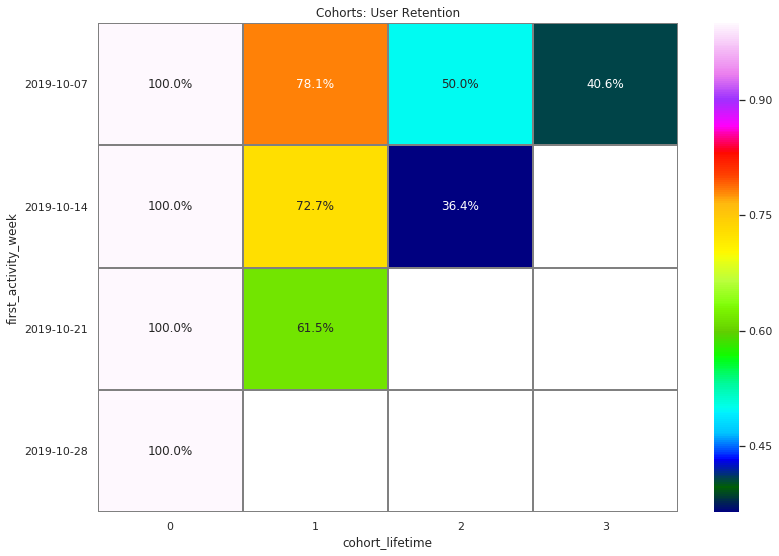

In [49]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',cmap='gist_ncar').set_yticklabels(retention_pivot.index.date)
plt.show()

В основном, 22-39%  не возвращается после первой недели.

**Для кластера 2:**

In [50]:
first_activity_date = cluster_2.groupby(['user_id'])['dt'].min()
first_activity_date.name = 'first_activity_date'
cluster_2 = cluster_2.join(first_activity_date,on='user_id')

In [51]:
cluster_2['activity_week'] = pd.to_datetime(cluster_2['dt'], unit='d') - pd.to_timedelta(cluster_2['dt'].dt.dayofweek, unit='d')
cluster_2['first_activity_week'] = pd.to_datetime(cluster_2['first_activity_date'], unit='d') - pd.to_timedelta(cluster_2['first_activity_date'].dt.dayofweek, unit='d')

In [52]:
cluster_2['cohort_lifetime']=cluster_2['activity_week']-cluster_2['first_activity_week']
cluster_2['cohort_lifetime']=cluster_2['cohort_lifetime']/np.timedelta64(1,'W')
cluster_2['cohort_lifetime']=cluster_2['cohort_lifetime'].astype('int')

In [53]:
cohorts=cluster_2.groupby(['first_activity_week','cohort_lifetime']).\
    agg({'user_id':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
cohorts=cohorts.merge(initial_users_count,on='first_activity_week')
cohorts['retention']=cohorts['user_id']/cohorts['cohort_users']
retention_pivot=cohorts.pivot_table(index='first_activity_week',columns='cohort_lifetime',values='retention',aggfunc='sum') 

In [54]:
retention_pivot

cohort_lifetime,0,1,2,3
first_activity_week,,,,
2019-10-07,1.0,0.692308,0.538462,0.423077
2019-10-14,1.0,0.818182,0.545455,NaN
2019-10-21,1.0,0.750000,NaN,NaN
2019-10-28,1.0,NaN,NaN,NaN


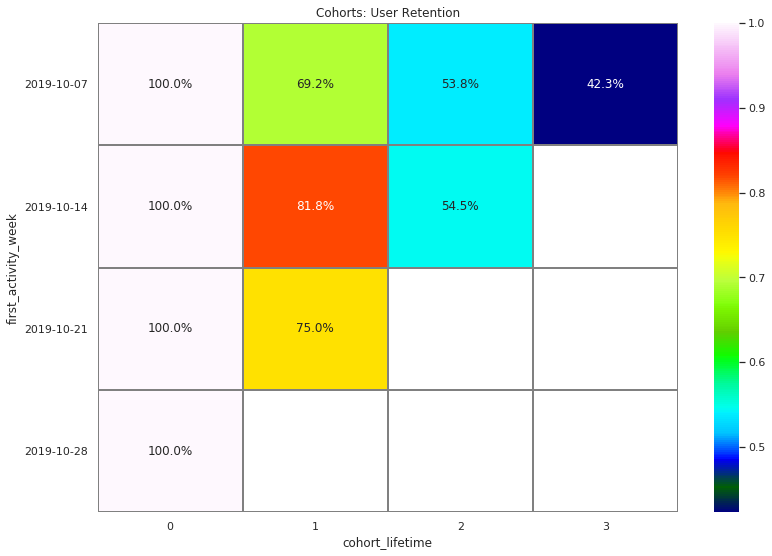

In [55]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',cmap='gist_ncar').set_yticklabels(retention_pivot.index.date)
plt.show()

В основном, 19-30%  не возвращается после первой недели.

**Для кластера 3:**

In [56]:
first_activity_date = cluster_3.groupby(['user_id'])['dt'].min()
first_activity_date.name = 'first_activity_date'
cluster_3 = cluster_3.join(first_activity_date,on='user_id')

In [57]:
cluster_3['activity_week'] = pd.to_datetime(cluster_3['dt'], unit='d') - pd.to_timedelta(cluster_3['dt'].dt.dayofweek, unit='d')
cluster_3['first_activity_week'] = pd.to_datetime(cluster_3['first_activity_date'], unit='d') - pd.to_timedelta(cluster_3['first_activity_date'].dt.dayofweek, unit='d')

In [58]:
cluster_3['cohort_lifetime']=cluster_3['activity_week']-cluster_3['first_activity_week']
cluster_3['cohort_lifetime']=cluster_3['cohort_lifetime']/np.timedelta64(1,'W')
cluster_3['cohort_lifetime']=cluster_3['cohort_lifetime'].astype('int')

In [59]:
cohorts=cluster_3.groupby(['first_activity_week','cohort_lifetime']).\
    agg({'user_id':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 
cohorts=cohorts.merge(initial_users_count,on='first_activity_week')
cohorts['retention']=cohorts['user_id']/cohorts['cohort_users']
retention_pivot=cohorts.pivot_table(index='first_activity_week',columns='cohort_lifetime',values='retention',aggfunc='sum') 

In [60]:
retention_pivot

cohort_lifetime,0,1,2,3
first_activity_week,,,,
2019-10-07,1.0,0.500000,0.357143,0.357143
2019-10-14,1.0,0.538462,0.538462,NaN
2019-10-21,1.0,0.500000,NaN,NaN
2019-10-28,1.0,NaN,NaN,NaN


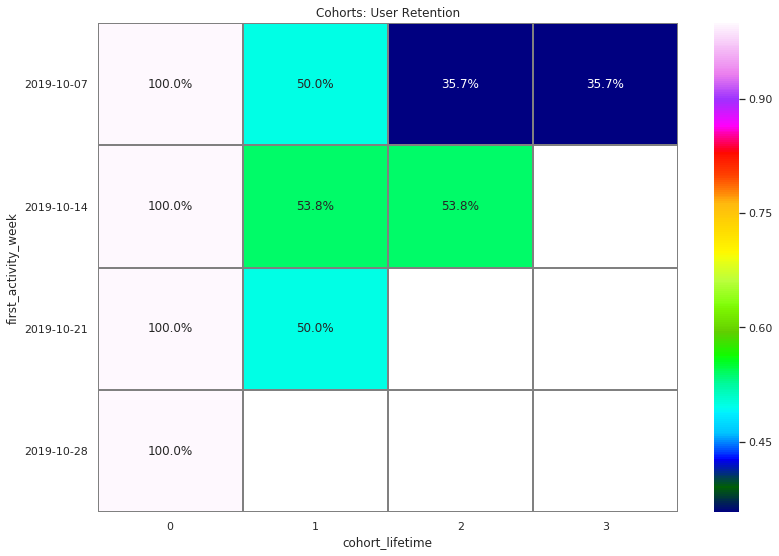

In [61]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',cmap='gist_ncar').set_yticklabels(retention_pivot.index.date)
plt.show()

В основном, 46-50%  не возвращается после первой недели.

### Время, проведённое в приложении

Посчитаем сессии разницами между которыми 1 час, найдем время средней сессии

Первый вход в приложение за час

In [62]:
min_time = df.groupby(['user_id', 'dt', 'event_hour'], as_index=False).agg({'event_time':'min'})
min_time = min_time.rename(columns={'event_time':'first_visit'})

Последний вход в приложение за час

In [63]:
max_time = df.groupby(['user_id', 'dt', 'event_hour'], as_index=False).agg({'event_time':'max'})
max_time = max_time.rename(columns={'event_time':'last_visit'})

Длина сессии

In [64]:
time_of_users=min_time.merge(max_time,on=['user_id','dt','event_hour'])
time_of_users['session']=time_of_users['last_visit']-time_of_users['first_visit']

Длина сессии в минутах

In [65]:
time_of_users['session'] = time_of_users['session'].astype('timedelta64[s]')/60

In [66]:
time_of_users=time_of_users.sort_values(by='session',ascending=False)

Количество сессий, длина которых не меньше 59 минут

In [67]:
len(time_of_users[time_of_users['session']>=59])

15

Количество сессий, длина которых равна 0 

In [68]:
len(time_of_users[time_of_users['session']==0])

2743

Время проведенное в приложении каждым пользователем

In [69]:
full_time=time_of_users.groupby('user_id').agg({'session':'sum'}).\
    sort_values(by='session',ascending=False)

In [70]:
marks=pd.merge(marks,full_time,on='user_id',how='left')

In [71]:
clusters=marks.groupby('cluster_km').agg({'session':'sum'}).\
    sort_values(by='session',ascending=False)
clusters['mean']=clusters['session']/users_of_cl['clusters_value']
clusters

,session,mean
cluster_km,,
0,92588.633333,22.533131
1,18825.433333,251.005778
2,8457.183333,122.567874
3,3804.300000,95.107500


### Частота действий

Кластер 0:

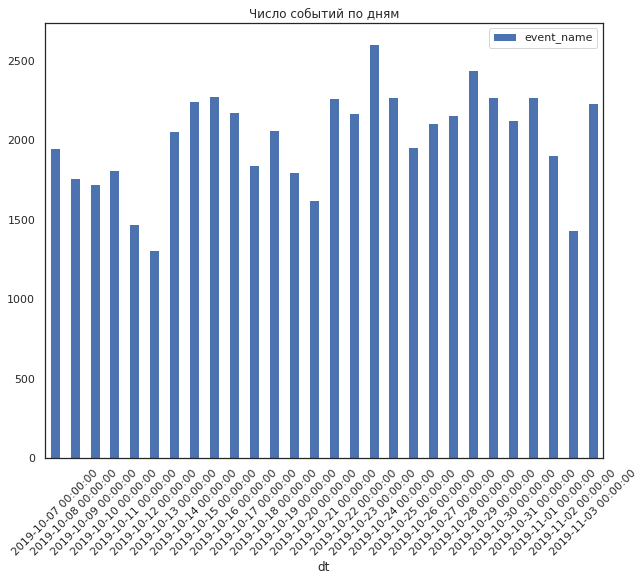

In [72]:
(cluster_0.groupby('dt').agg({'event_name': 'count'}).reset_index()
.plot.bar(x='dt', y='event_name', rot=45, figsize = (10, 8), title = 'Число событий по дням')
)

Кластер 1:

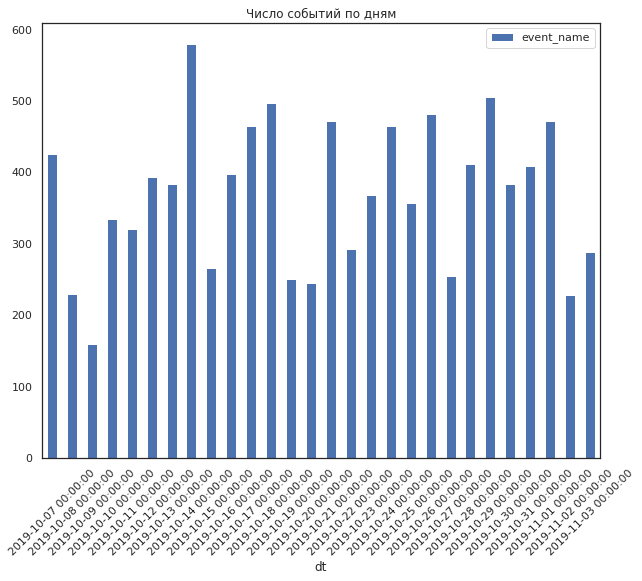

In [73]:
(cluster_1.groupby('dt').agg({'event_name': 'count'}).reset_index()
.plot.bar(x='dt', y='event_name', rot=45, figsize = (10, 8), title = 'Число событий по дням')
)

Кластер 2:

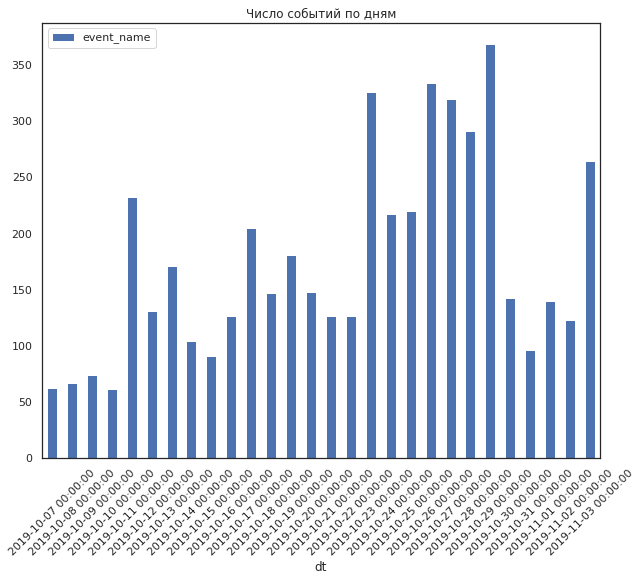

In [74]:
(cluster_2.groupby('dt').agg({'event_name': 'count'}).reset_index()
.plot.bar(x='dt', y='event_name', rot=45, figsize = (10, 8), title = 'Число событий по дням')
)

Кластер 3:

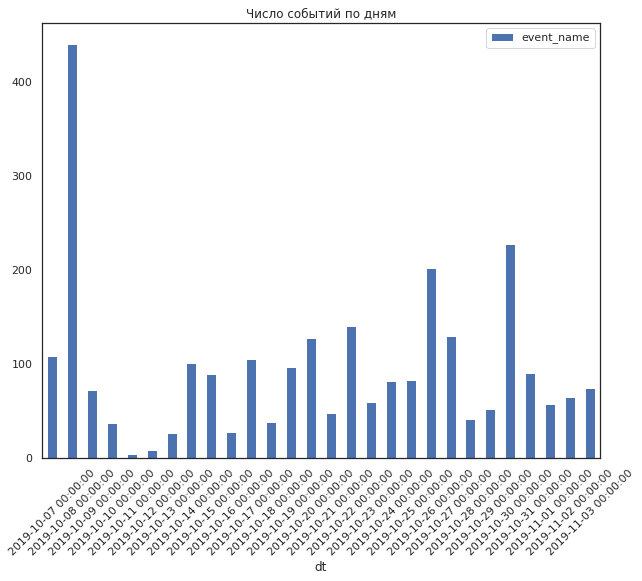

In [75]:
(cluster_3.groupby('dt').agg({'event_name': 'count'}).reset_index()
.plot.bar(x='dt', y='event_name', rot=45, figsize = (10, 8), title = 'Число событий по дням')
)

### Конверсия в целевое действие — просмотр контактов

Кластер 0:

In [76]:
(cluster_0.query('event_name=="contacts_show"')['user_id'].nunique() / cluster_0['user_id'].\
     nunique()) * 100

21.757118520321246

Кластер 1:

In [77]:
(cluster_1.query('event_name=="contacts_show"')['user_id'].nunique() / cluster_1['user_id'].\
     nunique()) * 100

53.333333333333336

Кластер 2:

In [78]:
(cluster_2.query('event_name=="contacts_show"')['user_id'].nunique() / cluster_2['user_id'].\
     nunique()) * 100

52.17391304347826

Кластер 3:

In [79]:
(cluster_3.query('event_name=="contacts_show"')['user_id'].nunique() / cluster_3['user_id'].\
     nunique()) * 100

27.500000000000004

### Выводы:

- 0 кластер-самый большой кластер (95,7%): в среднем по 22 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 21,76%, retention rate: 79-80% не возвращается после первой недели.
- 1 кластер - (1,75%): в среднем по 251 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 53,3%, retention rate: 22-39% не возвращается после первой недели.
- 2 кластер - (1,6%): в среднем по 122 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 52%, retention rate: 19-30% не возвращается после первой недели.
- 3 кластер - (0,93%): в среднем по 95 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 27,5%, retention rate: 46-50% не возвращается после первой недели.

## Проверка статистических гипотез 

### Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

*Нулевая гипотеза*: Конверсия в группе A равна конверсии в группе B

*Альтернативная гипотеза*: Конверсия в группе A не равна конверсии в группе B

In [80]:
total_users = sources.groupby('source', as_index=False).count().rename(columns={'user_id':'total_users'})
total_users

,source,total_users
0,google,1129
1,other,1230
2,yandex,1934


In [81]:
contacts_show_users = df.query('event_name=="contacts_show"').groupby(['source'], as_index=False).\
    agg({'user_id':'nunique'}).\
    rename(columns={'user_id':'contacts_show_users'})

In [82]:
hyp_1=pd.merge(total_users,contacts_show_users,on='source',how='left')
hyp_1['percent']=hyp_1['contacts_show_users']/hyp_1['total_users']
hyp_1

,source,total_users,contacts_show_users,percent
0,google,1129,275,0.243578
1,other,1230,228,0.185366
2,yandex,1934,478,0.247156


In [83]:
alpha = .05 

successes = np.array([275, 478])
trials = np.array([1129,1934])

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2 

z_value = difference / cmath.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)  
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница между конверсиями в 24,36% и 24,7% не оказалась значимой. p-значение оказалось чуть больше 82%.

### Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в действие добавления в избранное.

*Нулевая гипотеза*: Конверсия в группе A равна конверсии в группе B

*Альтернативная гипотеза*: Конверсия в группе A не равна конверсии в группе B

In [84]:
contacts_show_users = df.query('event_name=="favorites_add"').groupby(['source'], as_index=False).\
    agg({'user_id':'nunique'}).\
    rename(columns={'user_id':'favorites_add_users'})

In [85]:
hyp_2=pd.merge(total_users,contacts_show_users,on='source',how='left')
hyp_2['percent']=hyp_2['favorites_add_users']/hyp_2['total_users']
hyp_2

,source,total_users,favorites_add_users,percent
0,google,1129,114,0.100974
1,other,1230,77,0.062602
2,yandex,1934,160,0.082730


In [86]:
alpha = .05 

successes = np.array([114,160])
trials = np.array([1129, 1934])

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2 

z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1)  
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.08786519265881387
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница между конверсиями в 10% и 8% не оказалась значимой. p-значение оказалось чуть больше 8%.

## Общий вывод:

- Среднее уникальное количество пользователей в день - 279.
- Количество уникальных пользователей - 4293.
- Самое популярное действие среди уникальных пользователей tips_show (пользователь увидел рекомендованные объявления) - 2801. Затем search (разные события, связанные с поиском по сайту) - больше 1666. Действие map (пользователь открыл карту размещенных объявлений) - около 1456. Самые редкие действия - tips_click(пользователь кликнул по рекомендованному объявлению)- 322, contacts_call(пользователь позвонил по номеру телефона на карточке объявления)- 213.
- Самое популярное действие среди пользователей (и повторяющихся) tips_show (пользователь увидел рекомендованные объявления) - 40055. Затем photos_show (просмотр фотографий в объявлении) - больше 10000. Действие search (события, связанные с поиском по сайту) - около 6700. Самые редкие действия - tips_click(пользователь кликнул по рекомендованному объявлению), contacts_call(пользователь позвонил по номеру телефона на карточке объявления).
- По сегментации:
 - 0 кластер-самый большой кластер (95,7%): в среднем по 22 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 21,76%, retention rate: 79-80% не возвращается после первой недели.
 - 1 кластер - (1,75%): в среднем по 251 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 53,3%, retention rate: 22-39% не возвращается после первой недели.
 - 2 кластер - (1,6%): в среднем по 122 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 52%, retention rate: 19-30% не возвращается после первой недели.
 - 3 кластер - (0,93%): в среднем по 95 минуте на пользователя, конверсия в целевое действие — просмотр контактов - 27,5%, retention rate: 46-50% не возвращается после первой недели.

## Рекомендации

- увеличить поток пользователей из разных источников 
- ввести бонусы для активных пользователей
- улучшить алгоритм подбора рекомендованных объявлений

## Материалы

### Презентация: https://disk.yandex.ru/d/UZZFogRy_78rxQ

### Дашборд: https://public.tableau.com/profile/antonina.kolb#!/vizhome/dash20/Dashboard1